In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import numpy as np
import matplotlib.pyplot as plt
from quantization import quantizearray
from train_quantization import EfficientnetQAT, RoundWrapper, QuantizedWrapper, FakeQuantizeSTE

2025-03-03 19:42:43.214621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 19:42:43.227634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741048963.243507 3215412 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741048963.248200 3215412 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 19:42:43.264313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = torch.load('./images/test_training/runs679/epoch500_tacc0.998_vacc0.900.ckp', map_location=device)

In [4]:
import torch.utils

transform_test = transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

model.eval()
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0)

_, [images, lablels] = next(enumerate(testloader))
print(images.shape)
preds = model.forward(images)
print(preds)

Files already downloaded and verified
torch.Size([1, 3, 224, 224])
tensor([[-5.3086, -5.3086, -5.3086,  4.6450, -5.3086, -1.9907, -4.6450, -5.3086,
         -5.3086, -5.3086]], grad_fn=<RoundWrapperBackward>)


cnt: 0


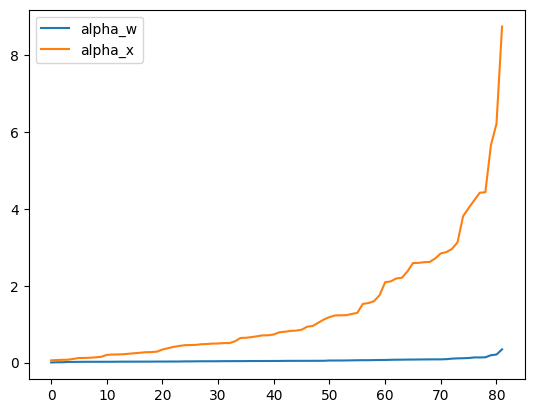

In [5]:
alpha_ws = []
alpha_xs = []
cnt = 0
for name, param in model.named_parameters():
    if name.split('.')[-1] == 'alpha_w':
        alpha_ws.append(param.item())
    elif name.split('.')[-1] == 'alpha_x':
        alpha_xs.append(param.item())

print(f'cnt: {cnt}')
alpha_ws.sort()
alpha_xs.sort()
plt.plot(alpha_ws, label='alpha_w')
plt.plot(alpha_xs, label='alpha_x')
plt.legend()

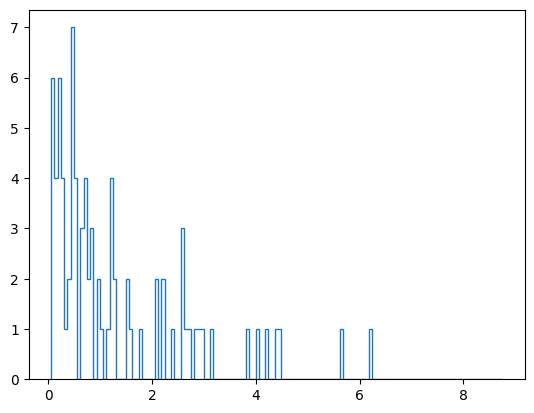

In [ ]:
step_size_x = 1/pow(2, 4)
xmin, xmax = min(alpha_xs), max(alpha_xs)
bins = [xmin+i*step_size_x for i in range(1+int((xmax - xmin)//step_size_x))]
counts = [0 for i in range(len(bins)-1)]

for xi in range(len(alpha_xs)):
    for bi in range(len(bins)-1):
        if bins[bi] <= alpha_xs[xi] < bins[bi+1] or (bins[bi] <= alpha_xs[xi] < bins[bi+1] and bi+1 == len(bins)):
            counts[bi] += 1
            break
plt.stairs(counts, bins)

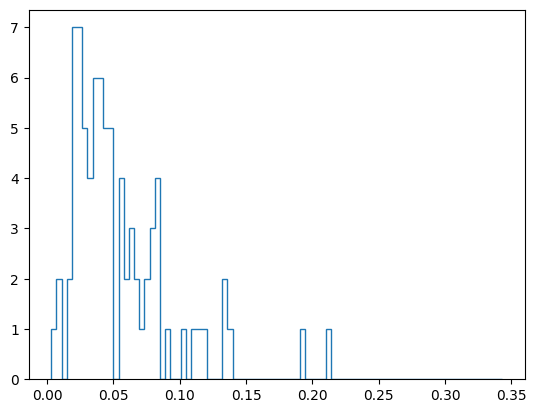

In [8]:
step_size_w = 1/pow(2, 8)
wmin, wmax = min(alpha_ws), max(alpha_ws)
bins = [wmin+i*step_size_w for i in range(1+int((wmax - wmin)//step_size_w))]
counts = [0 for i in range(len(bins)-1)]

for wi in range(len(alpha_ws)):
    for bi in range(len(bins)-1):
        if bins[bi] <= alpha_ws[wi] < bins[bi+1] or (bins[bi] <= alpha_ws[xi] < bins[bi+1] and bi+1 == len(bins)):
            counts[bi] += 1
            break
plt.stairs(counts, bins)

In [11]:
bias_false = 0
bias_true = 0

for module in model.modules():
    if isinstance(module, QuantizedWrapper):
        subnet = module.module
        if subnet.bias == None:
            bias_false+=1
        else:
            bias_true+=1
print(f'bias_false: {bias_false}, bias_true: {bias_true}')

bias_false: 49, bias_true: 33
